In [1]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.applications import DenseNet121
from functools import reduce
from tensorflow.keras.models import load_model

def rgb_to_three_channel_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return tf.repeat(grayscale_image, repeats=3, axis=-1)

def preprocess_image(rgb_path, target_size=(200, 200)):
    rgb_image = tf.io.read_file(rgb_path)
    rgb_image = tf.image.decode_png(rgb_image, channels=3)
    rgb_image = tf.image.resize(rgb_image, target_size)
    return rgb_image / 255.0

def parse_image_filename(filename, zones):
    match = re.search(r'image\.(\d+)\.rgb\.png', filename)
    if match:
        azimuth = int(match.group(1)) % 360
        return azimuth // (360 // zones)
    return 0

def split_dataset(data, split_ratios=(0.8, 0.1, 0.1)):
    indices = np.random.permutation(len(data))
    split1 = int(split_ratios[0] * len(data))
    split2 = split1 + int(split_ratios[1] * len(data))
    return [data[i] for i in indices[:split1]], [data[i] for i in indices[split1:split2]], [data[i] for i in indices[split2:]]

def create_dataset(image_paths, labels, preprocess_func):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_func, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds))

def load_images_from_directory(base_dir, preprocess_func, split_ratios=(0.7, 0.2, 0.1), zones = 4):
    all_image_paths, all_labels = [], []
    for folder_name in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in sorted(os.listdir(folder_path)):
                if filename.endswith(".rgb.png"):
                    file_path = os.path.join(folder_path, filename)
                    all_image_paths.append(file_path)
                    all_labels.append(parse_image_filename(filename, zones))

    # Shuffle the dataset
    indices = np.random.permutation(len(all_image_paths))
    all_image_paths = np.array(all_image_paths)[indices]
    all_labels = np.array(all_labels)[indices]

    # Split the dataset
    train_size = int(len(all_image_paths) * split_ratios[0])
    val_size = int(len(all_image_paths) * split_ratios[1])

    train_paths = all_image_paths[:train_size]
    val_paths = all_image_paths[train_size:train_size + val_size]
    test_paths = all_image_paths[train_size + val_size:]

    train_labels = all_labels[:train_size]
    val_labels = all_labels[train_size:train_size + val_size]
    test_labels = all_labels[train_size + val_size:]

    # Create datasets
    train_ds = create_dataset(train_paths, train_labels, preprocess_func)
    val_ds = create_dataset(val_paths, val_labels, preprocess_func)
    test_ds = create_dataset(test_paths, test_labels, preprocess_func)

    return train_ds, val_ds, test_ds

def create_densenet_model(input_shape=(200, 200, 3), num_classes=4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    for layer in base_model.layers:
        layer.trainable = True
    return model


def compile_and_train_model(model, train_ds, val_ds, epochs=1, zones = 4):
    # Configure the checkpoint to save the best model
    checkpoint = ModelCheckpoint(
        f'best_model_zones_{zones}.h5',  # Path where the model will be saved
        monitor='val_loss',  # Metric to monitor
        save_best_only=True,  # Save only the best model
        verbose=1  # Verbosity level
    )
    
    # Optional: Add early stopping to halt training when validation metric stops improving
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,  # Number of epochs with no improvement after which training will be stopped
        verbose=1
    )

    # Optional: Add TensorBoard to visualize training dynamics
    tensorboard = TensorBoard(log_dir='./azimuth_zone_logs')

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[checkpoint, early_stopping, tensorboard]  # Include the checkpoint in the callbacks
    )
    
    return history


base_dir = '../data/raw_experimental_data'

evaluation_results = {
    'zones': [],
    'loss': [],
    'accuracy': []
}

zone_divisions = [12, 18, 36, 72, 120, 180, 360]
for zone in zone_divisions:
    train_ds, val_ds, test_ds = load_images_from_directory(
        base_dir, 
        lambda path: preprocess_image(path, (200, 200)), 
        split_ratios=(0.7, 0.2, 0.1),
        zones = zone,
    )

    model = create_densenet_model(num_classes=zone)
    history = compile_and_train_model(model, train_ds.batch(32), val_ds.batch(32), epochs=10, zones = zone)
    best_model = load_model(f'best_model_zones_{zone}.h5')

    results = best_model.evaluate(test_ds.batch(32), verbose=1)
    evaluation_results['zones'].append(zone)
    evaluation_results['loss'].append(results[0])
    evaluation_results['accuracy'].append(results[1])




2993/2993 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9393
Epoch 9: val_loss improved from 0.46415 to 0.37902, saving model to best_model_zones_180.h5
2993/2993 [==============================] - 265s 88ms/step - loss: 0.1724 - accuracy: 0.9393 - val_loss: 0.3790 - val_accuracy: 0.8873
Epoch 10/10
2993/2993 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9463
Epoch 10: val_loss did not improve from 0.37902
428/428 [==============================] - 10s 21ms/step - loss: 0.3632 - accuracy: 0.8913
Epoch 1/10
2992/2993 [============================>.] - ETA: 0s - loss: 3.1562 - accuracy: 0.1194
Epoch 1: val_loss improved from inf to 2.18136, saving model to best_model_zones_360.h5
2993/2993 [==============================] - 285s 86ms/step - loss: 3.1561 - accuracy: 0.1194 - val_loss: 2.1814 - val_accuracy: 0.1992
Epoch 2/10
2993/2993 [==============================] - ETA: 0s - loss: 1.8887 - accuracy: 0.2798
Epoch 2: val_loss improved 

In [2]:
evaluation_results

{'zones': [12, 18, 36, 72, 120, 180, 360],
 'loss': [0.03552253916859627,
  0.031869176775217056,
  0.09372848272323608,
  0.21205177903175354,
  0.28909173607826233,
  0.36316585540771484,
  0.46652188897132874],
 'accuracy': [0.9871345162391663,
  0.9890350699424744,
  0.9713450074195862,
  0.9325292110443115,
  0.9017543792724609,
  0.891301155090332,
  0.8831140398979187]}

In [3]:
evaluation_results = {
    'zones': [],
    'loss': [],
    'accuracy': []
}

zone_divisions = [4, 6, 12, 18, 36, 72, 120, 180, 360]
for zone in zone_divisions:
    
    train_ds, val_ds, test_ds = load_images_from_directory(
        base_dir, 
        lambda path: preprocess_image(path, (200, 200)), 
        split_ratios=(0.7, 0.2, 0.1),
        zones = zone,
    )
    
    
    
    best_model = load_model(f'az_models_densenet/best_model_zones_{zone}.h5')

    results = best_model.evaluate(test_ds.batch(32), verbose=1)
    evaluation_results['zones'].append(zone)
    evaluation_results['loss'].append(results[0])
    evaluation_results['accuracy'].append(results[1])


428/428 [==============================] - 10s 21ms/step - loss: 0.2831 - accuracy: 0.9209


In [12]:
real_image_paths = ["/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3703.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3704.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3705.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3706.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4090.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4091.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4092.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4096.png", 
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4097.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4098.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4099.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4100.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4101.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4102.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4103.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4104.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4105.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4106.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4107.png"]
real_elevation_labels = [0, 0, 45, 45, 0, 0, 0, 75, 75, 75, 0, 0, 75, 0, 0, 0, 0, 0, 0]  # Dummy elevation values
real_azimuth_labels = [105, 250, 275, 305, 100, 3, 280, 90, 40, 135, 175, 268, 267, 95, 45, 285, 330, 1, 90]  # Dummy azimuth values

def preprocess_real_images(image_path):
    # This assumes the preprocess function and grayscale conversion are correctly defined
    rgb_image = tf.io.read_file(image_path)
    rgb_image = tf.image.decode_png(rgb_image, channels=3)  # Adjust if images are not PNG
    rgb_image = tf.image.resize(rgb_image, [200, 200])
    rgb_image = rgb_image / 255.0  # Normalize to [0,1]
    return rgb_image  # Assuming this function is defined

def preprocess_image(image_path):
    """Load and preprocess an image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Assuming images are in PNG format
    image = tf.image.resize(image, [200, 200])  # Resize to the desired size for your model
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image  # Here, keep it in RGB if that's what the model expects

def create_tf_dataset(image_paths, elevation_labels, azimuth_labels):
    """Create a TensorFlow dataset from image paths and labels."""
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices({
        'elevation': tf.cast(elevation_labels, tf.int64),
        'azimuth': tf.cast(azimuth_labels, tf.int64)  // (360)
    })

    # Combine into a single dataset
    dataset = tf.data.Dataset.zip((image_ds, labels_ds))
    return dataset

real_dataset = create_tf_dataset(real_image_paths, real_elevation_labels, real_azimuth_labels)
real_dataset = real_dataset.batch(32)  # Batch the dataset for model evaluation or visualization



1/1 [==============================] - 0s 18ms/step


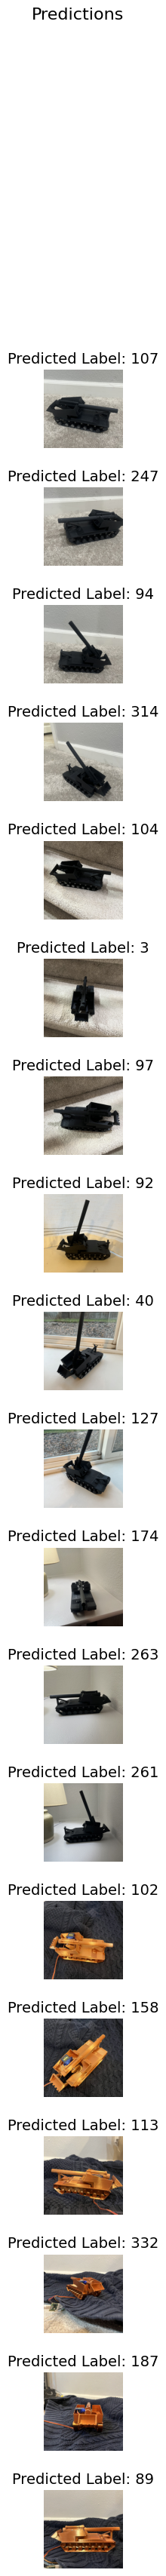

In [24]:
import matplotlib.pyplot as plt

def predict_and_visualize(model, dataset, sample_size=24):
    """
    Predicts using the model on the dataset and visualizes the results in a vertical layout.
    
    Args:
    model (tf.keras.Model): The trained model.
    dataset (tf.data.Dataset): The dataset for prediction.
    sample_size (int): Number of predictions to visualize.
    """
    # Take samples for prediction
    sample_dataset = dataset.take(sample_size)
    
    # Since the dataset is batched, predictions and visualization must handle batches
    for images, labels in sample_dataset:  # Iterate over batches
        predictions = model.predict(images)  # Predict a whole batch

        plt.figure(figsize=(6, 2 * sample_size))  # Adjust the figure size for vertical layout
        plt.suptitle('Predictions', fontsize=16)

        for i, image in enumerate(images):  # Now iterate over images in the batch
            plt.subplot(sample_size, 1, i + 1)  # Change subplot to arrange images vertically
            predicted_label = np.argmax(predictions[i])
            plt.imshow(image.numpy().squeeze(), cmap='gray')  # Adjust color mapping if necessary
            plt.title(f"Predicted Label: {predicted_label}", fontsize=14)  # Adjust font size
            plt.axis('off')

        plt.subplots_adjust(hspace=0.5)  # Adjust the horizontal spacing between subplots
        plt.show()

# Example of how to call the function
predict_and_visualize(best_model, real_dataset)

In [5]:
real_image_paths = ["/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3703.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3704.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3705.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_3706.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4090.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4091.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4092.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4096.png", 
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4097.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4098.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4099.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4100.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4101.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4102.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4103.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4104.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4105.png",
                    "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4106.png", "/home/andrey/msds_practicum/msds_practicum/data/real_data/image_4107.png"]
real_elevation_labels = [0, 0, 45, 45, 0, 0, 0, 75, 75, 75, 0, 0, 75, 0, 0, 0, 0, 0, 0]  # Dummy elevation values
real_azimuth_labels = [105, 250, 275, 305, 100, 3, 280, 90, 40, 135, 175, 268, 267, 95, 45, 285, 330, 1, 90]  # Dummy azimuth values
import tensorflow as tf
import numpy as np
import tensorflow as tf
import numpy as np

import tensorflow as tf
import numpy as np

def preprocess_real_images(image_path):
    # This assumes the preprocess function and grayscale conversion are correctly defined
    rgb_image = tf.io.read_file(image_path)
    rgb_image = tf.image.decode_png(rgb_image, channels=3)  # Adjust if images are not PNG
    rgb_image = tf.image.resize(rgb_image, [200, 200])
    rgb_image = rgb_image / 255.0  # Normalize to [0,1]
    return rgb_to_three_channel_grayscale(rgb_image)  # Assuming this function is defined

def rgb_to_three_channel_grayscale(image):
    """Convert an RGB image to 3-channel grayscale."""
    grayscale = tf.image.rgb_to_grayscale(image)
    grayscale = tf.tile(grayscale, [1, 1, 3])  # Repeat the grayscale channel three times
    return grayscale

def preprocess_image(image_path):
    """Load and preprocess an image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Assuming images are in PNG format
    image = tf.image.resize(image, [200, 200])  # Resize to the desired size for your model
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image  # Here, keep it in RGB if that's what the model expects

def create_tf_dataset(image_paths, elevation_labels, azimuth_labels):
    """Create a TensorFlow dataset from image paths and labels."""
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices({
        'elevation': tf.cast(elevation_labels, tf.int64),
        'azimuth': tf.cast(azimuth_labels, tf.int64)  // (360/zones)
    })

    # Combine into a single dataset
    dataset = tf.data.Dataset.zip((image_ds, labels_ds))
    return dataset

real_dataset = create_tf_dataset(real_image_paths, real_elevation_labels, real_azimuth_labels)
real_dataset = real_dataset.batch(32)  # Batch the dataset for model evaluation or visualization



NameError: name 'zones' is not defined

In [ ]:
test_ds

In [ ]:
real_dataset

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_samples_with_predictions(dataset, model, title, num_samples=3):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        if images.shape[0] < num_samples:
            raise ValueError("Not enough samples in the batch. Increase batch size or reduce num_samples.")
        
        # Get model predictions
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)  # Assuming model outputs logits or softmax
        
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy())
            
            # Adjust how labels are accessed based on your dataset structure
            # Check if labels are a dictionary and adjust accordingly
            if isinstance(labels, dict):
                actual_label = f"Elevation: {labels['elevation'][i].numpy()}, Azimuth: {labels['azimuth'][i].numpy()}"
            else:
                actual_label = labels[i].numpy()
                
            predicted_label = predicted_labels[i]
            plt.title(f"True: {actual_label}\nPred: {predicted_label}")
            plt.axis('off')
    plt.show()

# Example usage, make sure the model and datasets are correctly configured
batch_size = 3
plot_samples_with_predictions(real_dataset.batch(batch_size), model, "Real Dataset")

# Ensure the model is correctly loaded and compiled
# Assuming `model` is your loaded and compiled model and the datasets are batched

plot_samples_with_predictions(train_ds.batch(batch_size), model, "Training Samples")
plot_samples_with_predictions(val_ds.batch(batch_size), model, "Validation Samples")
plot_samples_with_predictions(test_ds.batch(batch_size), model, "Test Samples")


NameError: name 'real_dataset' is not defined

In [ ]:
real_dataset = create_tf_dataset(real_image_paths, real_elevation_labels, real_azimuth_labels)

# Example of how to check dataset structure
for images, labels in real_dataset.take(1):
    print(f"Image shape: {images.shape}, Label: {labels}")